In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
import seaborn as sns
from scipy import stats
from lightgbm import LGBMRegressor

%matplotlib inline

Чтение данных

In [2]:
df = pd.read_csv("train_titanik.csv") # чтение датафрейма из файла

df.set_index('PassengerId',inplace=True)

print('Строк в датасете:' , df.shape[0])

Строк в датасете: 891


In [3]:
df.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


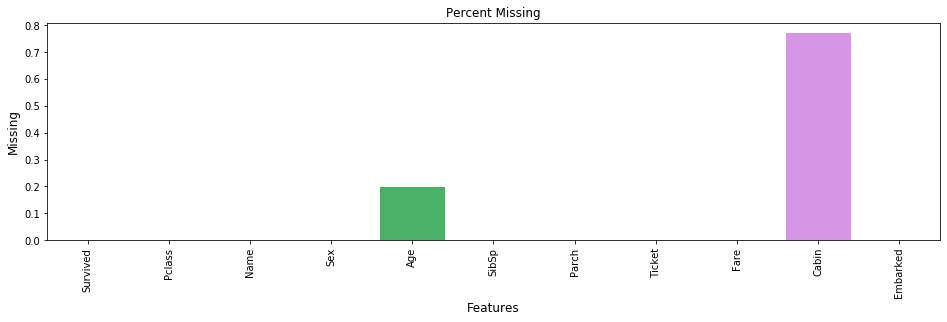

In [5]:
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()
# нужно заполнить пустые значения в столбце "Age"
# значения в столбце "Cabin" переведем в категориальные

In [6]:
# заполнение пустых ячеек 'Age'
def med_age(Pclass, Sex):
    
    med_age = round(df['Age'].loc[(df['Pclass'] == Pclass) & (df['Sex'] == Sex)].median(),0)
    
    return med_age

for i in range(1,4):
    df.loc[(df['Age'].isnull()) & (df['Pclass'] == i) & (df['Sex'] == 'male'),'Age'] = med_age(i, 'male')
    df.loc[(df['Age'].isnull()) & (df['Pclass'] == i) & (df['Sex'] == 'female'),'Age'] = med_age(i, 'female')


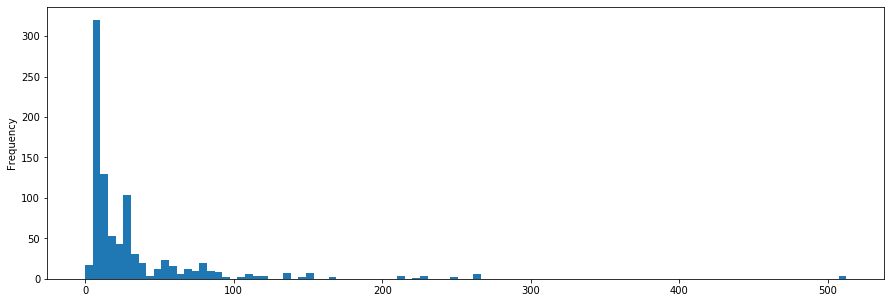

In [7]:
#plt.figure(figsize=(15,5))
df['Fare'].plot.hist(bins=100,figsize=(15,5))
plt.show()

# 'Fare' больше 300 - это выброс

In [8]:
df = df.loc[df['Fare'] < 300] # удалить строки, в которых стоимость билета более 300

In [9]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.sex_cat = None
        self.age_cat = None
        self.embarked_to_cat = None
        self.cabin_to_bool = None
            
    def transform(self, X):
        X['Sex'].astype('category')
        X['Embarked'].astype('category')
        X['Pclass'].astype('category')
        
        X.loc[X['Sex'] == 'male', 'sex_cat'] = 0
        X.loc[X['Sex'] == 'female', 'sex_cat'] = 1
        
        X.loc[(X['Age'] < 18.0), 'age_cat'] = 1
        X.loc[(X['Age'] >= 18.0) & (X['Age'] < 35.0), 'age_cat'] = 2
        X.loc[(X['Age'] >= 35.0) & (X['Age'] < 65.0), 'age_cat'] = 3
        X.loc[(X['Age'] >= 65.0), 'age_cat'] = 4
        
        X.loc[X['Embarked'] == 'S', 'embarked_to_cat'] = 1
        X.loc[X['Embarked'] == 'C', 'embarked_to_cat'] = 2
        X.loc[X['Embarked'] == 'Q', 'embarked_to_cat'] = 3
        X.drop('Embarked', axis=1, inplace=True)
       
        X.loc[X['Cabin'].isnull() == False, 'cabin_to_bool'] = 1
        X.loc[X['Cabin'].isnull() == True, 'cabin_to_bool'] = 0
        
        X.drop('Sex', axis=1, inplace=True)
        X.drop('Age', axis=1, inplace=True)
        X.drop('Cabin', axis=1, inplace=True)
        X.drop('Name', axis=1, inplace=True)
        X.drop('Ticket', axis=1, inplace=True)
        
        return X

In [10]:
features = FeatureGenetator()

df = features.transform(df)
df.head(20)

,Survived,Pclass,SibSp,Parch,Fare,sex_cat,age_cat,embarked_to_cat,cabin_to_bool
PassengerId,,,,,,,,,
1,0,3,1,0,7.2500,0.0,2.0,1.0,0.0
2,1,1,1,0,71.2833,1.0,3.0,2.0,1.0
3,1,3,0,0,7.9250,1.0,2.0,1.0,0.0
4,1,1,1,0,53.1000,1.0,3.0,1.0,1.0
5,0,3,0,0,8.0500,0.0,3.0,1.0,0.0
6,0,3,0,0,8.4583,0.0,2.0,3.0,0.0
7,0,1,0,0,51.8625,0.0,3.0,1.0,1.0
8,0,3,3,1,21.0750,0.0,1.0,1.0,0.0
9,1,3,0,2,11.1333,1.0,2.0,1.0,0.0


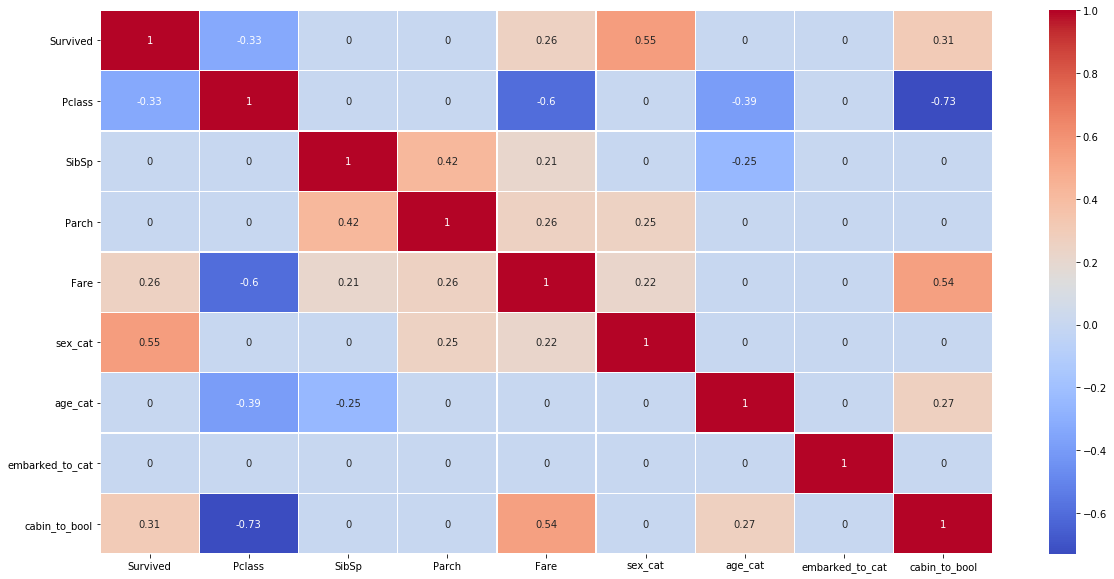

In [11]:
corr_matrix = df.corr() # матрица корреляций
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0 # убрать корреляцию менеем 0,2
fig, ax = plt.subplots(figsize=(20,10)) # задаем размер фигуры  
sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, cmap = 'coolwarm', ax = ax) # строим тепловую карту корреляций

Проверка зависимости между класссом путевки и шансом спастись (чем выше класс, тем выше шанс)

In [43]:
# имеем три группы пассажиров: 1-го класса, 2-го класса, 3-го класса

y1 = df.loc[df['Pclass'] == 1]
# найдем среднее значение выживших в этой категории пассажиров
Survived_y1 = sum(map(lambda i: i == 1, y1['Survived']))
Survived_percent_y1 = Survived_y1 / y1.shape[0]
print(f'Процент выживших в 1-м классе: {round(Survived_percent_y1,3) * 100} %') # фактический процент выживших от общего числа пасажиров в 1-м классе

Процент выживших в 1-м классе: 62.4 %


In [47]:
y2 = df.loc[df['Pclass'] == 2]
# найдем среднее значение выживших в этой категории пассажиров
Survived_y2 = sum(map(lambda i: i == 1, y2['Survived']))
Survived_percent_y2 = Survived_y2 / y2.shape[0]
print(f'Процент выживших во 2-м классе: {round(Survived_percent_y2,3) * 100} %') # фактический процент выживших от общего числа пасажиров в 1-м классе

Процент выживших во 2-м классе: 47.3 %


In [46]:
y3 = df.loc[df['Pclass'] == 3]
# найдем среднее значение выживших в этой категории пассажиров
Survived_y3 = sum(map(lambda i: i == 1, y3['Survived']))
Survived_percent_y3 = Survived_y3 / y3.shape[0]
print(f'Процент выживших в 3-м классе: {round(Survived_percent_y3,3) * 100} %') # фактический процент выживших от общего числа пасажиров в 1-м классе

Процент выживших в 3-м классе: 24.2 %


In [50]:
Survived = sum(map(lambda i: i == 1, df['Survived']))
Survived_percent = Survived / df.shape[0]
print(f'Процент выживших от общего числа пассажиров: {round(Survived_percent,3) * 100} %') # фактический процент выживших от общего числа пасажиров в 1-м классе

Процент выживших от общего числа пассажиров: 38.2 %


Видно, что средние проценты выживших разнятся. Установим, что это отличие статистически значимо.
# 1. как проверить статистическую значимость? ни сумму квадратов отклонений, ни дисперсию в данном случае не посчитать

# 2. Почему получается так, что корреляция между "выживанием" и "классом" всего лишь 0,33, а процент выживших в 1-м классе в 1,3 раза больше, чем вв 2-м классе и в 2,5 раза больше, чем в 3-м класссе.РАзве это не должно давай бОльшее значение корреляции? 

Проверка гипотезы, что 80% спавшихся людей, это люди в возрасте от 18 до 35 лет

In [51]:
df['Survived'].value_counts()
#print(df.shape[0])

0    549
1    339
Name: Survived, dtype: int64

In [54]:
df_Survived = df.loc[df['Survived'] == 1]
df_Survived['age_cat'].value_counts()

2.0    173
3.0    104
1.0     61
4.0      1
Name: age_cat, dtype: int64

In [56]:
Survived_adult = sum(map(lambda i: i == 2, df_Survived['age_cat']))
aaa = Survived_adult / df_Survived.shape[0]
aaa

0.5103244837758112

Вывод: гипотеза №2 отклоняется